# Image semantic segmentation

### Библиотеки

In [1]:
import os, shutil, pathlib, random
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

In [2]:
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Conv2D, Conv2DTranspose, MaxPooling2D, BatchNormalization, \
                                    Dropout, Flatten, Activation, Input, concatenate
from tensorflow.keras.utils import to_categorical, load_img, img_to_array
import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np

# from tensorflow.python.framework.ops import disable_eager_execution
# disable_eager_execution()
    
# tf.compat.v1.disable_eager_execution()

### Проход файлов датасета

In [3]:
PATH_DATASET = r"D:\BigDataSets\ImageSegmentation\oxford-iiit-pet"
PATH_INPUT = os.path.join(PATH_DATASET, r"images")
PATH_TARGET = os.path.join(PATH_DATASET, r"annotations\trimaps")

input_img_paths = sorted(
    [os.path.join(PATH_INPUT, fname) for fname in os.listdir(PATH_INPUT) 
     if (fname.endswith(".jpg"))])

target_paths = sorted(
    [os.path.join(PATH_TARGET, fname) for fname in os.listdir(PATH_TARGET)
    if (fname.endswith(".png") and not fname.startswith("."))])

target_labels = ['_'.join(fname.split('\\')[-1].split('_')[:-1]).capitalize()
                 for fname in input_img_paths]
label_to_id = dict()
id_to_label = dict()
for i, n in enumerate(sorted(set(target_labels))):
    label_to_id[n] = i
    id_to_label[i] = n
target_labels_id = np.array([label_to_id[label] for label in target_labels])

print(len(input_img_paths), len(target_paths), *input_img_paths[:3], *target_labels[:3], label_to_id, sep='\n')

7390
7390
D:\BigDataSets\ImageSegmentation\oxford-iiit-pet\images\Abyssinian_1.jpg
D:\BigDataSets\ImageSegmentation\oxford-iiit-pet\images\Abyssinian_10.jpg
D:\BigDataSets\ImageSegmentation\oxford-iiit-pet\images\Abyssinian_100.jpg
Abyssinian
Abyssinian
Abyssinian
{'Abyssinian': 0, 'American_bulldog': 1, 'American_pit_bull_terrier': 2, 'Basset_hound': 3, 'Beagle': 4, 'Bengal': 5, 'Birman': 6, 'Bombay': 7, 'Boxer': 8, 'British_shorthair': 9, 'Chihuahua': 10, 'Egyptian_mau': 11, 'English_cocker_spaniel': 12, 'English_setter': 13, 'German_shorthaired': 14, 'Great_pyrenees': 15, 'Havanese': 16, 'Japanese_chin': 17, 'Keeshond': 18, 'Leonberger': 19, 'Maine_coon': 20, 'Miniature_pinscher': 21, 'Newfoundland': 22, 'Persian': 23, 'Pomeranian': 24, 'Pug': 25, 'Ragdoll': 26, 'Russian_blue': 27, 'Saint_bernard': 28, 'Samoyed': 29, 'Scottish_terrier': 30, 'Shiba_inu': 31, 'Siamese': 32, 'Sphynx': 33, 'Staffordshire_bull_terrier': 34, 'Wheaten_terrier': 35, 'Yorkshire_terrier': 36}


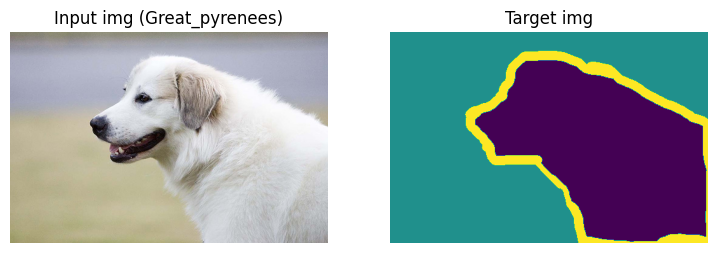

In [4]:
idx = random.randint(0, len(input_img_paths))
plt.figure(figsize=(9, 4))

# Input
plt.subplot(1, 2, 1)
plt.title(f"Input img ({target_labels[idx]})")
plt.axis("off")
plt.imshow(load_img(input_img_paths[idx]))

# Target
def display_target(target_array):  # make (1, 2, 3) -> (0, 1, 2) * 127 + 1 -> [0..255]
    normalized_array = (target_array.astype("uint8") - 1) * 127 + 1
    plt.axis("off")
    plt.imshow(normalized_array[:, :, 0])

t_img = img_to_array(load_img(target_paths[idx], color_mode="grayscale"))
plt.subplot(1, 2, 2)
plt.title("Target img")
display_target(t_img)
plt.show()

### Создание датасета (загрузка изображений)

In [4]:
NUM_CLASSES = 3
IMG_SIZE = (256, 256)
NUM_IMGS = len(input_img_paths)

In [5]:
random.Random(2006).shuffle(input_img_paths)
random.Random(2006).shuffle(target_paths)
random.Random(2006).shuffle(target_labels)  # lb
random.Random(2006).shuffle(target_labels_id)  # lb

num_val_samples = 1000

train_input_imgs  = input_img_paths[:-num_val_samples]
train_target_imgs = target_paths[:-num_val_samples]
train_labels      = target_labels_id[:-num_val_samples]  # lb

val_input_imgs  = input_img_paths[-num_val_samples:]
val_target_imgs = target_paths[-num_val_samples:]
val_labels      = target_labels_id[-num_val_samples:]  # lb

In [6]:
def path_to_input_image(path):
    return img_to_array(load_img(path, target_size=IMG_SIZE, color_mode="rgb")) / 255.

def path_to_target(path):
    img = img_to_array(
    load_img(path, target_size=IMG_SIZE, color_mode="grayscale"))
    img = img.astype("uint8") - 1  # -> (0, 1, 2)
    return img

def load_data(img_path, target_path):
    return (path_to_input_image(img_path), path_to_target(target_path))

def _fixup_shape(images, targets):
    images.set_shape(IMG_SIZE + (3,))
    targets.set_shape(IMG_SIZE + (1,))
    return images, targets

def make_dataset(x, y, batch_size: int, prefetch=True):
    ds = tf.data.Dataset.from_tensor_slices((np.array(x), np.array(y)))
    
    ds = ds.map(lambda x, y: tf.numpy_function(load_data, [x, y], [tf.float32, tf.uint8]),
                num_parallel_calls=tf.data.AUTOTUNE)    # Загрузка изображения
    ds = ds.map(_fixup_shape)                           # Исправление tf error with shapes (ds = ds.__iter__())
    ds = ds.shuffle(batch_size * 10).batch(batch_size)  # Перемешивать и выделять пакеты (drop_remainder=True)
    ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)      # Предварительная загрузка данных для скорости
    ds = ds.cache()                                     # Кеширование
    
    return ds


train_ds = make_dataset(train_input_imgs, train_target_imgs, batch_size=64)
val_ds   = make_dataset(val_input_imgs,   val_target_imgs,   batch_size=64)

# train_label_ds   = make_dataset(train_input_imgs, train_labels,  batch_size=64)  # lb
# val_label_ds     = make_dataset(val_input_imgs,   val_labels,    batch_size=64)  # lb

In [7]:
for im, tr in train_ds.take(1):
    print(im, tr)
    print(im.shape, tr.shape)

tf.Tensor(
[[[[0.25882354 0.11764706 0.03137255]
   [0.2627451  0.12156863 0.03529412]
   [0.28627452 0.14509805 0.05882353]
   ...
   [0.3529412  0.1764706  0.09411765]
   [0.34509805 0.16862746 0.08627451]
   [0.32941177 0.15294118 0.07058824]]

  [[0.2627451  0.12156863 0.03529412]
   [0.2627451  0.12156863 0.03529412]
   [0.2627451  0.12156863 0.03529412]
   ...
   [0.3529412  0.1764706  0.09411765]
   [0.3529412  0.1764706  0.09411765]
   [0.36078432 0.18431373 0.10196079]]

  [[0.25490198 0.11372549 0.02745098]
   [0.24313726 0.10196079 0.01568628]
   [0.25882354 0.11764706 0.03137255]
   ...
   [0.34901962 0.17254902 0.09019608]
   [0.34509805 0.16862746 0.08627451]
   [0.36078432 0.18431373 0.10196079]]

  ...

  [[0.21568628 0.06666667 0.01568628]
   [0.22352941 0.07058824 0.01176471]
   [0.23921569 0.07450981 0.01176471]
   ...
   [0.31764707 0.13333334 0.05490196]
   [0.36078432 0.1764706  0.09803922]
   [0.35686275 0.17254902 0.09411765]]

  [[0.21568628 0.06666667 0.023529

### Models

In [8]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=4,
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.8,
        min_lr=7e-5,
        patience=1,
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath="model_.keras",
        monitor="val_loss",
        save_best_only=True,
    ),
#     tf.keras.callbacks.TensorBoard(
#         log_dir="logs",
#         histogram_freq=2,
#         write_images=True,
#     ),
]

#### Model 1 (simple)

In [10]:
seg_model = Sequential([
    Input(shape=IMG_SIZE+(3,)),                                             # 256
    Conv2D(64, 3, activation="relu", padding="same", strides=2),            # 128
    Conv2D(64, 3, activation="relu", padding="same"),                       # 128
    Conv2D(128, 3, activation="relu", padding="same", strides=2),           # 64
    Conv2D(128, 3, activation="relu", padding="same"),                      # 64
    Conv2D(256, 3, activation="relu", padding="same", strides=2),           # 32
    Conv2D(256, 3, activation="relu", padding="same"),                      # 32
    
    Conv2DTranspose(256, 3, activation="relu", padding="same"),             # 32
    Conv2DTranspose(256, 3, activation="relu", padding="same", strides=2),  # 64
    Conv2DTranspose(128, 3, activation="relu", padding="same"),             # 64
    Conv2DTranspose(128, 3, activation="relu", padding="same", strides=2),  # 128
    Conv2DTranspose(64, 3, activation="relu", padding="same"),              # 128
    Conv2DTranspose(64, 3, activation="relu", padding="same", strides=2),   # 256
    
    Conv2D(NUM_CLASSES, 3, activation="softmax", padding="same"),           # 256
])

seg_model.summary()

# Epoch 7/100
# 100/100 [==============================] - 78s 766ms/step - loss: 0.6913 - accuracy: 0.7141
# val_loss: 0.7059 val_accuracy: 0.7105

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      36928     
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 128)       147584    
                                                                 
 conv2d_4 (Conv2D)           (None, 32, 32, 256)       295168    
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 256)       590080    
                                                                 
 conv2d_transpose (Conv2DTra  (None, 32, 32, 256)      5

#### Model 2 (U-net)

In [9]:
inp = Input(shape=IMG_SIZE+(3,))                                                                   # 256
x1 = Conv2D(32, 3, activation="relu", padding="same", strides=2)(inp)                              # 128
x2 = Conv2D(64, 3, activation="relu", padding="same")(x1)                                          # 128
x3 = Conv2D(64, 3, activation="relu", padding="same", strides=2)(x2)                              # 64
x4 = Conv2D(128, 3, activation="relu", padding="same")(x3)                                         # 64
x5 = Conv2D(128, 3, activation="relu", padding="same", strides=2)(x4)                              # 32
features = Conv2D(256, 3, activation="relu", padding="same")(x5)                                   # 32

h5 = Conv2DTranspose(256, 3, activation="relu", padding="same")(features)                          # 32
h4 = Conv2DTranspose(128, 3, activation="relu", padding="same", strides=2)(h5)                     # 64
h3 = Conv2DTranspose(128, 3, activation="relu", padding="same")(concatenate([h4, x4]))             # 64
h2 = Conv2DTranspose(64, 3, activation="relu", padding="same", strides=2)(concatenate([h3, x3]))  # 128
h1 = Conv2DTranspose(64, 3, activation="relu", padding="same")(concatenate([h2, x2]))              # 128
h0 = Conv2DTranspose(32, 3, activation="relu", padding="same", strides=2)(concatenate([h1, x1]))   # 256

out = Conv2D(NUM_CLASSES, 3, activation="softmax", padding="same")(concatenate([h0, inp]))         # 256

seg_model = Model(inp, out)
seg_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 64  18496       ['conv2d[0][0]']                 
                                )                                                             

### Fit model

In [10]:
seg_model.compile(
    RMSprop(0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

history = seg_model.fit(train_ds, epochs=100,
                        validation_data=val_ds, callbacks=callbacks)

Epoch 1/100
100/100 [==============================] - 116s 897ms/step - loss: 1.4660 - accuracy: 0.5723 - val_loss: 0.8793 - val_accuracy: 0.5739 - lr: 0.0010
Epoch 2/100
100/100 [==============================] - 62s 617ms/step - loss: 0.8726 - accuracy: 0.5896 - val_loss: 0.9598 - val_accuracy: 0.5062 - lr: 0.0010
Epoch 3/100
100/100 [==============================] - 60s 605ms/step - loss: 0.7528 - accuracy: 0.6648 - val_loss: 0.6944 - val_accuracy: 0.7021 - lr: 8.0000e-04
Epoch 4/100
100/100 [==============================] - 61s 609ms/step - loss: 0.7041 - accuracy: 0.6961 - val_loss: 0.6508 - val_accuracy: 0.7189 - lr: 8.0000e-04
Epoch 5/100
100/100 [==============================] - 60s 604ms/step - loss: 0.6778 - accuracy: 0.7124 - val_loss: 0.6529 - val_accuracy: 0.7358 - lr: 8.0000e-04
Epoch 6/100
100/100 [==============================] - 60s 604ms/step - loss: 0.6256 - accuracy: 0.7389 - val_loss: 0.5866 - val_accuracy: 0.7628 - lr: 6.4000e-04
Epoch 7/100
100/100 [========

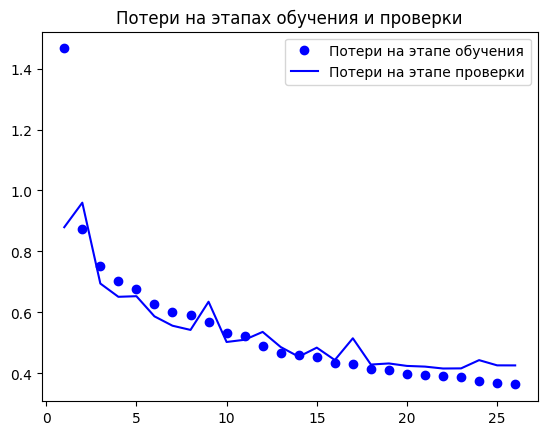

In [11]:
epochs = range(1, len(history.history["loss"]) + 1)
loss = history.history["loss"]
val_loss = history.history["val_loss"]
plt.figure()
plt.plot(epochs, loss, "bo", label="Потери на этапе обучения")
plt.plot(epochs, val_loss, "b", label="Потери на этапе проверки")
plt.title("Потери на этапах обучения и проверки")
plt.legend()
plt.show()

### Show test

In [7]:
model = tf.keras.models.load_model("model_Unet.keras")

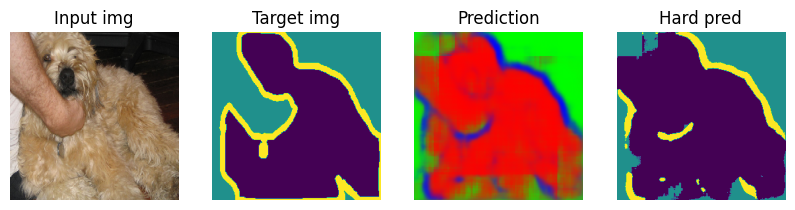

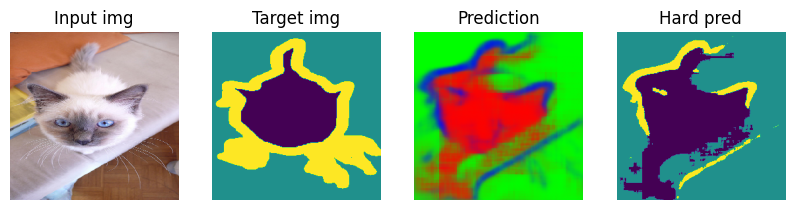

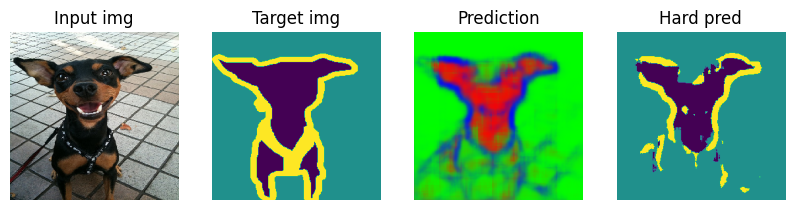

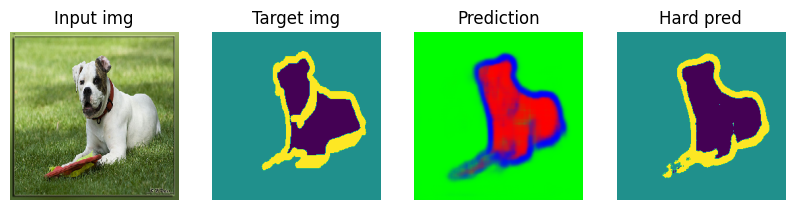

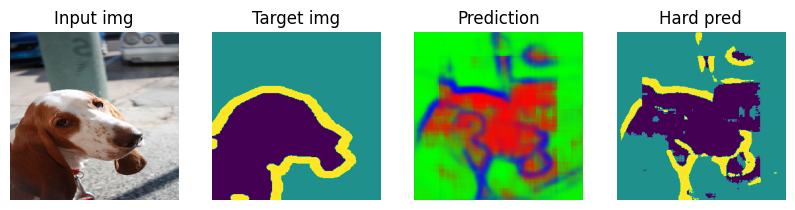

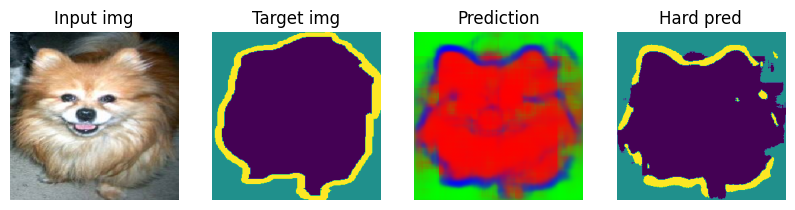

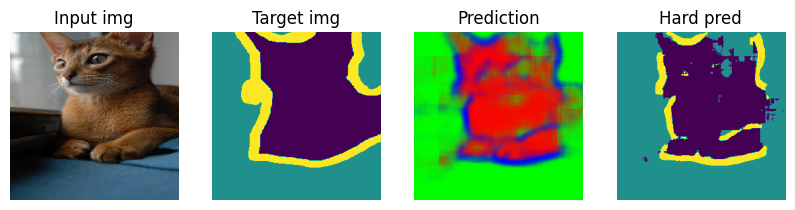

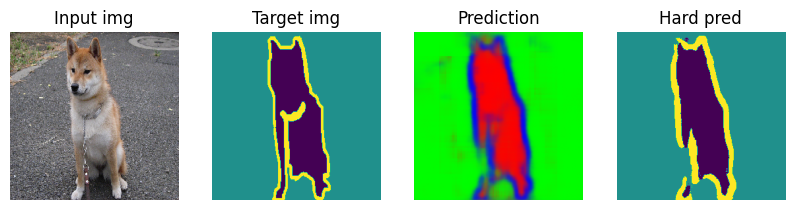

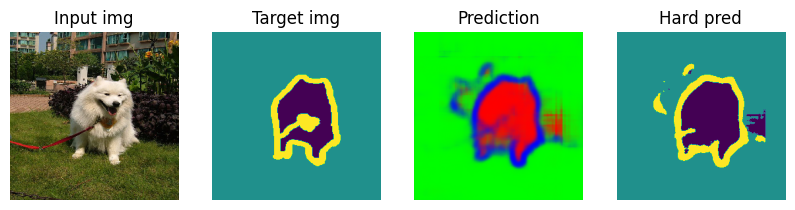

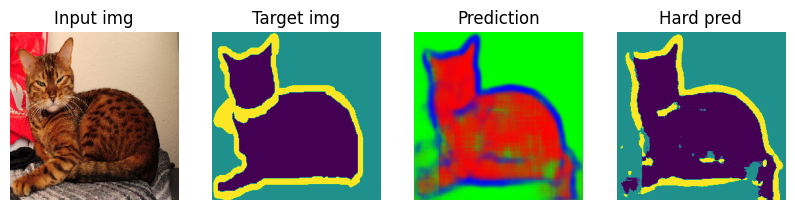

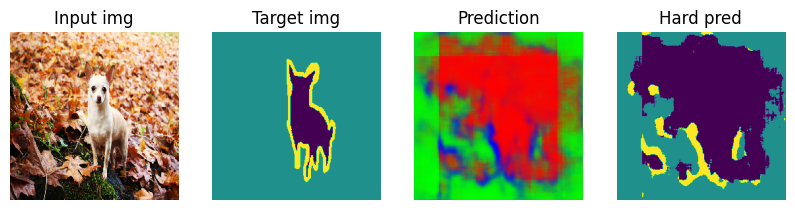

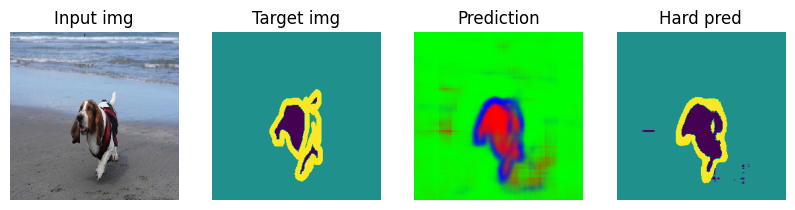

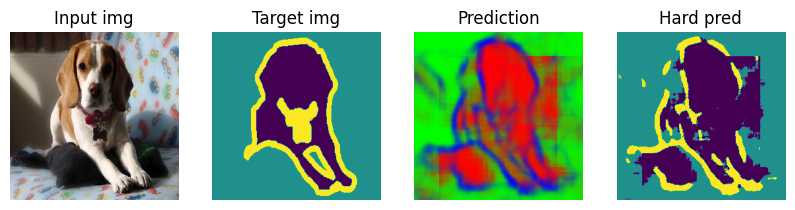

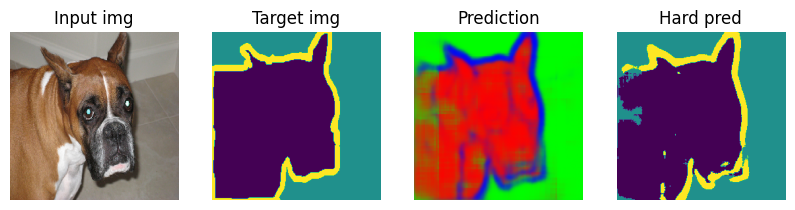

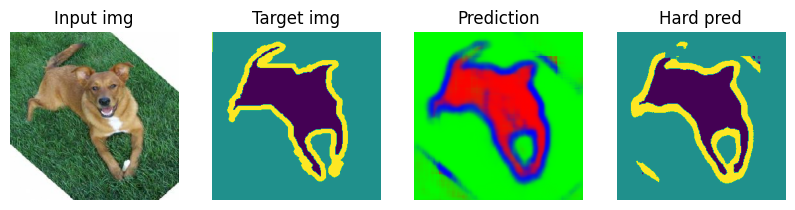

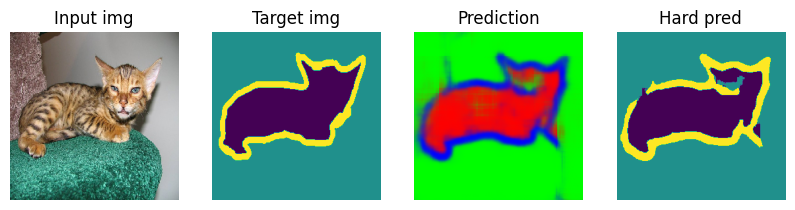

In [8]:
def display_mask(pred, hide=True):
    if hide:
        pred = np.argmax(pred, axis=-1)
        pred *= 127
    plt.axis("off")
    plt.imshow(pred)


for im, tr in val_ds.take(20):
    idx = 0
    test_image = im[idx].numpy()
    test_target = tr[idx].numpy()
    
    plt.figure(figsize=(10, 4))
    
    plt.subplot(1, 4, 1)
    plt.title(f"Input img")
    plt.axis("off")
    plt.imshow(test_image)
    
    plt.subplot(1, 4, 2)
    plt.title("Target img")
    test_target *= 127
    plt.axis("off")
    plt.imshow(test_target)
    
    pred = model.predict(np.expand_dims(test_image, 0), verbose=0)[0]
    
    plt.subplot(1, 4, 3)
    plt.title("Prediction")
    display_mask(pred, False)
    
    plt.subplot(1, 4, 4)
    plt.title("Hard pred")
    display_mask(pred)
    
    plt.show()